In [13]:
# Import necessary libraries
import numpy as np
import pandas as pd
import warnings
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn_lvq import GlvqModel
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore", message="Values in x were outside bounds during a minimize step")


#  Load and preprocess data
iris = load_iris()
X, y = iris.data, iris.target
feature_names = iris.feature_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train GLVQ model with patched optimizer
model = GlvqModel(prototypes_per_class=2, random_state=42)
original_optimize = model._optimize

def patched_optimize(x, y, random_state):
    original_shape = model.w_.shape
    model.w_ = model.w_.ravel()
    original_optimize(x, y, random_state)
    model.w_ = model.w_.reshape(original_shape)

model._optimize = patched_optimize
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
acc = np.mean(y_pred == y_test)
print(f"Accuracy: {acc:.2f}")

Accuracy: 0.93


In [14]:
from scipy.optimize import minimize
import numpy as np

def generate_cf_glvq_constrained(model, x_orig, y_target, C=1.0, epsilon=1e-3, bounds=None, verbose=False):
    """
    Generate counterfactual for GLVQ using proximity objective + hard margin constraint.

    Parameters:
    - model: trained GLVQ model
    - x_orig: original input sample (numpy array)
    - y_target: desired target class (int)
    - C: proximity regularization weight (float)
    - epsilon: small positive constant for numerical stability (float)
    - bounds: optional bounds for input features (list of tuples)
    - verbose: whether to print debug info

    Returns:
    - x_cf: counterfactual input (numpy array)
    - delta: change applied to original input (numpy array)
    - m_val: final margin value (float)
    """
    prototypes = model.w_
    labels = model.c_w_

    if not any(c == y_target for c in labels):
        raise ValueError(f"No prototype for target class {y_target}")

    def closest_dist(x, cls):
        dists = [np.sum((x - w) ** 2) for w, c in zip(prototypes, labels) if c == cls]
        return min(dists)

    def margin(x):
        d_plus = closest_dist(x, y_target)
        d_minus = min(np.sum((x - w) ** 2) for w, c in zip(prototypes, labels) if c != y_target)
        denom = d_plus + d_minus 
        return (d_plus - d_minus) / denom

    def loss(x):
        # Only proximity term
        prox = C * np.sum((x - x_orig) ** 2)
        return prox

    if bounds is None:
        bounds = [(-3, 3)] * len(x_orig)

    constraints = [
        {'type': 'ineq', 'fun': lambda x: -margin(x)}  # margin(x) <= 0
    ]

    result = minimize(
        loss,
        x0=x_orig,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
        options={'maxiter': 1000}
    )

    if result.success:
        x_cf = result.x
        delta = x_cf - x_orig
        m_val = margin(x_cf)
        if verbose:
            print(f"CF found. Margin: {m_val:.6f}, Δ norm: {np.linalg.norm(delta):.4f}")
        return x_cf, delta, m_val
    else:
        if verbose:
            print(f"Optimization failed: {result.message}")
        return None, None, None


In [15]:
#  Generate CFs + collect stats for table
table_data = []
success_count = 0
margin_but_no_flip_count = 0
fail_count = 0
sample_indices = range(50)

for idx in sample_indices:
    x_sample = X_test[idx]  # Replace with your actual test input array
    y_orig = model.predict([x_sample])[0]
    y_target = 0
    
    try:
        x_cf, delta, m_val = generate_cf_glvq_constrained(model, x_sample, y_target, C=0.1)
    except ValueError:
        fail_count += 1
        orig_vals = scaler.inverse_transform([x_sample])[0]
        row = {
            "Index": idx,
            "Original Prediction": y_orig,
            "Target Prediction": y_target,
            "Class Flip Success": " (error)",
            "Δ Norm": "-"
        }
        for name, val in zip(feature_names, orig_vals):
            row[name] = f"{val:.3f}"
        row["Original Features"] = ", ".join(f"{name}={val:.3f}" for name, val in zip(feature_names, orig_vals))
        table_data.append(row)
        continue

    if x_cf is not None:
        y_cf = model.predict([x_cf])[0]
        flip_success = "Yes" if y_cf == y_target else "No"
        delta_norm = np.linalg.norm(delta)
        if flip_success == "Yes":
            success_count += 1
        else:
            margin_but_no_flip_count += 1
    else:
        flip_success = " (opt fail)"
        delta_norm = "-"
        fail_count += 1

    orig_vals = scaler.inverse_transform([x_sample])[0]
    row = {
        "Index": idx,
        "Original Prediction": y_orig,
        "Target Prediction": y_target,
        "Class Flip Success": flip_success,
        "Δ Norm": f"{delta_norm:.4f}" if isinstance(delta_norm, float) else delta_norm
    }
    for name, val in zip(feature_names, orig_vals):
        row[name] = f"{val:.3f}"
    row["Original Features"] = ", ".join(f"{name}={val:.3f}" for name, val in zip(feature_names, orig_vals))
    table_data.append(row)


In [16]:
#  Create and display DataFrame
cf_df = pd.DataFrame(table_data)

print("\nFeature columns:")
for name in feature_names:
    print(f"- {name}")

print("\nCounterfactual Summary Table (first 5 rows):")
print(cf_df.head(50))

#cf_df.to_csv("counterfactual_summary.csv", index=False)
#print(" Counterfactual summary saved to counterfactual_summary.csv")

# 6️⃣ Print summary
print("\nSummary:")
print(f"Total samples: {len(X_test)}")
print(f"Successful CFs (class flip achieved): {success_count}")
print(f"CFs with margin but no class flip: {margin_but_no_flip_count}")
print(f"Failed CFs (optimization failed or no valid target class): {fail_count}")



Feature columns:
- sepal length (cm)
- sepal width (cm)
- petal length (cm)
- petal width (cm)

Counterfactual Summary Table (first 5 rows):
    Index  Original Prediction  Target Prediction Class Flip Success  Δ Norm  \
0       0                    1                  0                 No  1.6605   
1       1                    0                  0                Yes  0.0000   
2       2                    2                  0         (opt fail)       -   
3       3                    1                  0                 No  1.5590   
4       4                    1                  0                Yes  2.0811   
5       5                    0                  0                Yes  0.0000   
6       6                    1                  0                 No  1.0199   
7       7                    2                  0                 No  2.2181   
8       8                    1                  0         (opt fail)       -   
9       9                    1                  0         

In [17]:
iris.target_names = np.array(iris.target_names)
print("\nClass labels:")
for i, name in enumerate(iris.target_names):
    print(f"{i}: {name}")


Class labels:
0: setosa
1: versicolor
2: virginica


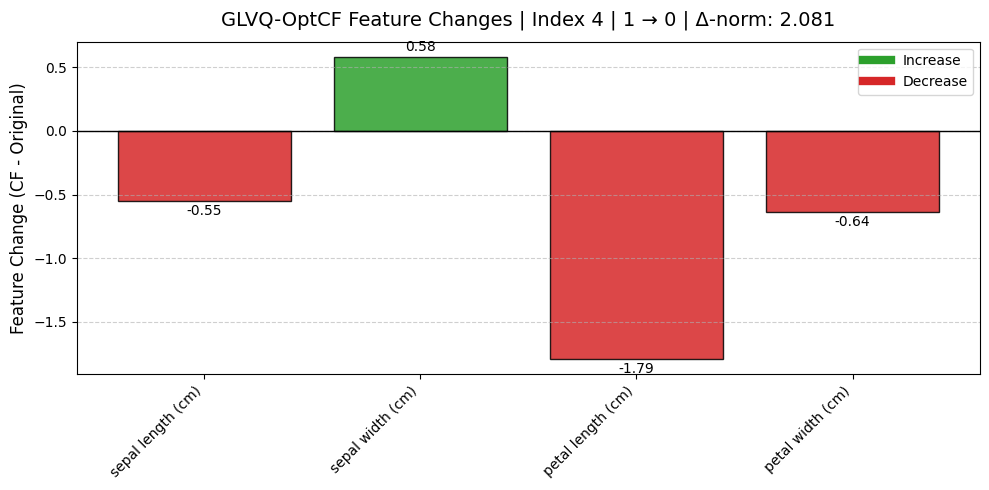

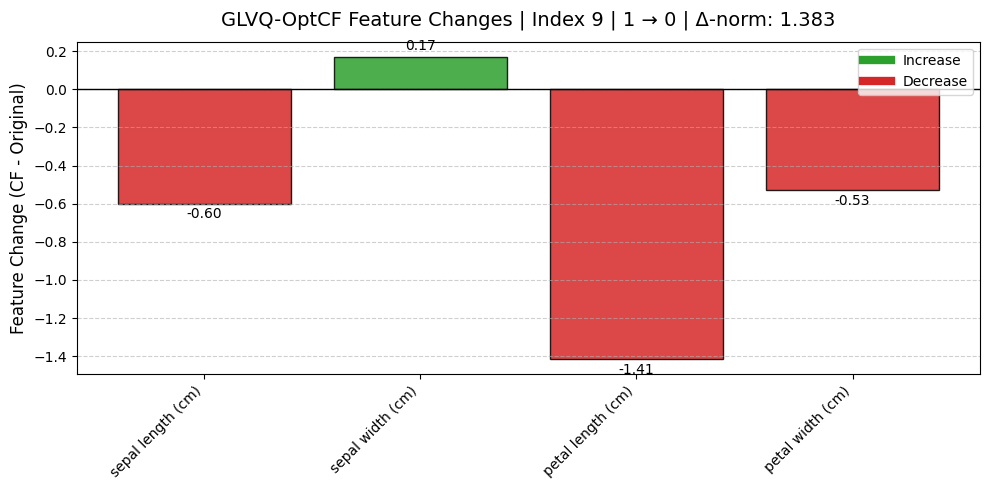

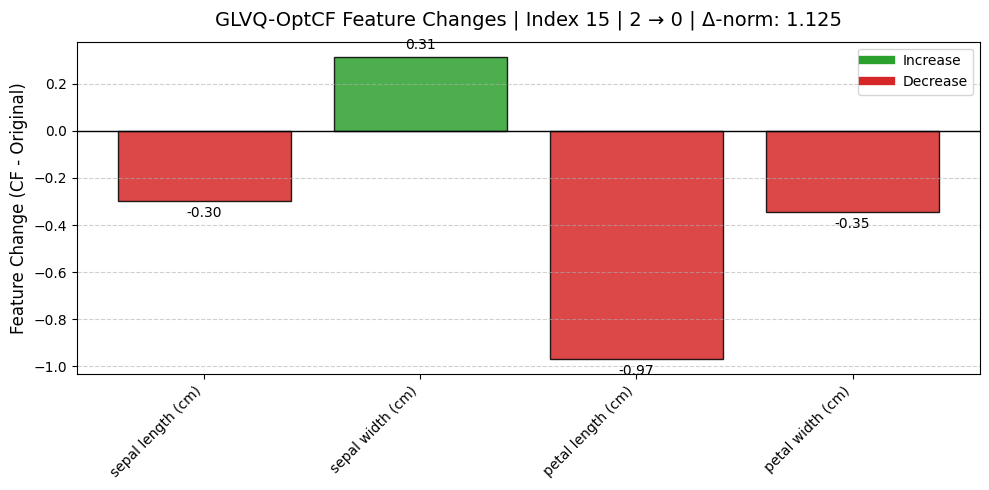

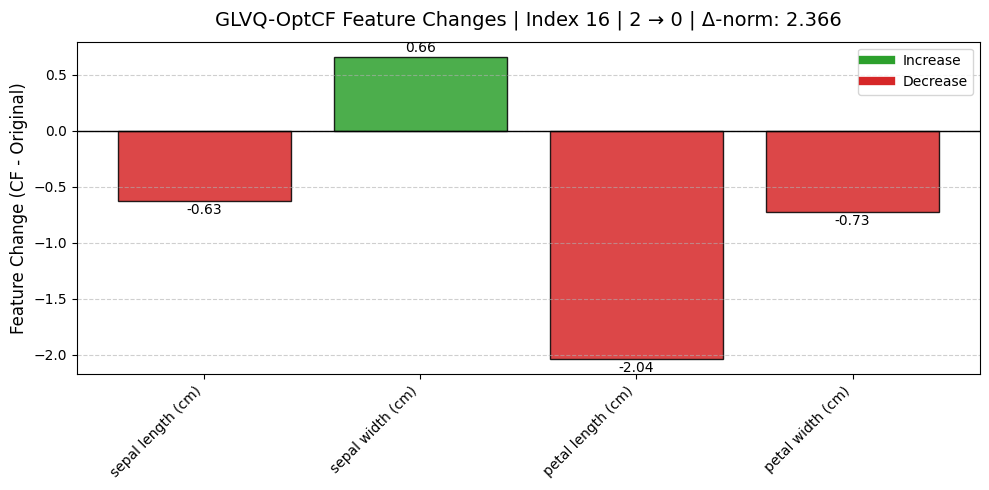

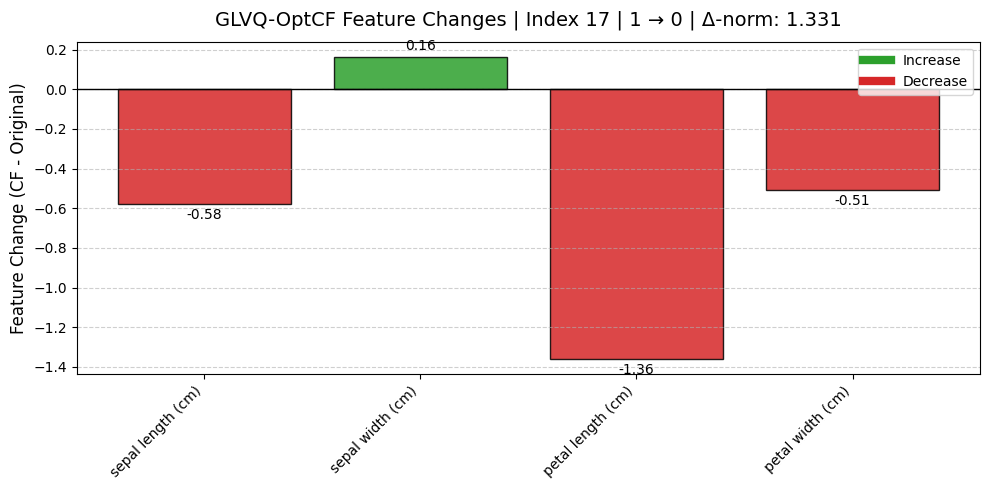

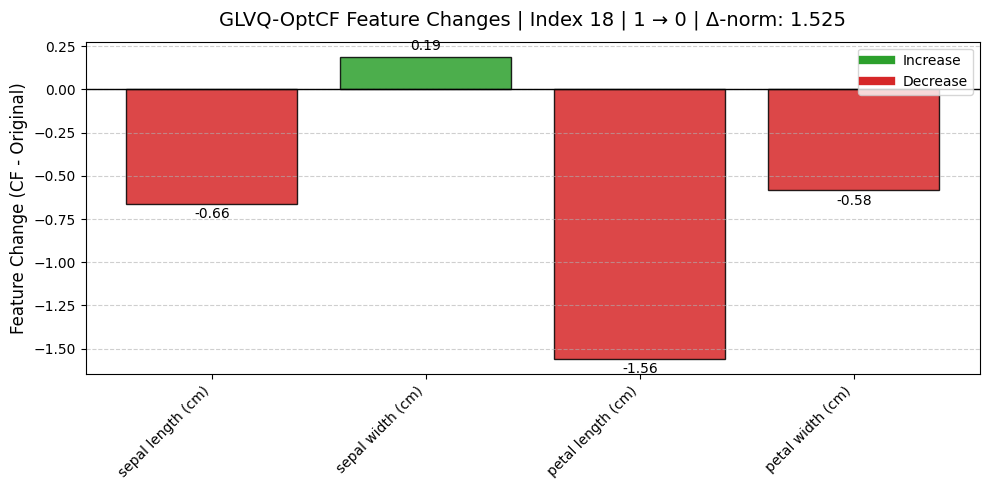

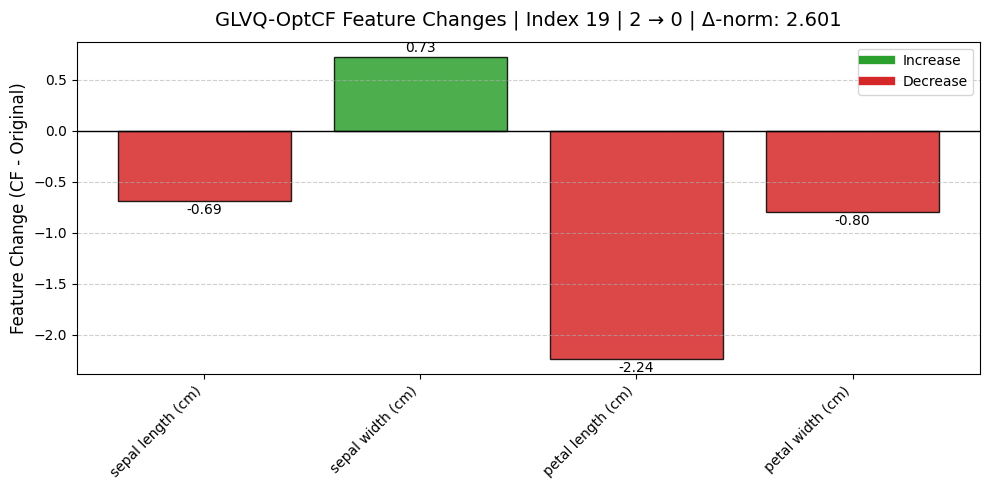

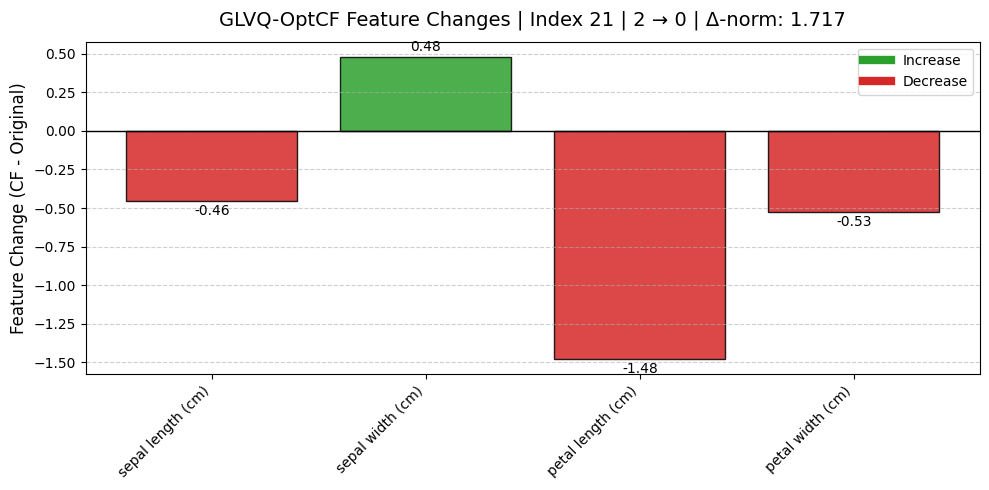

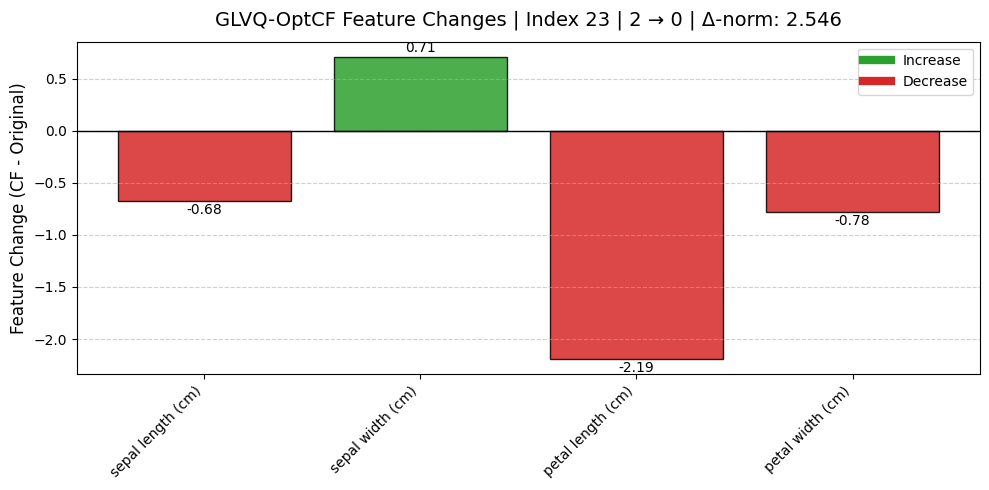

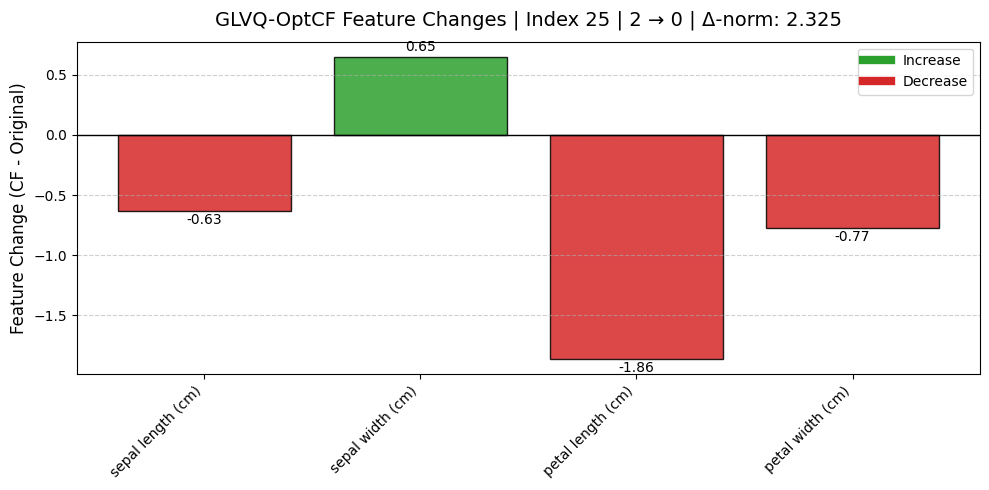

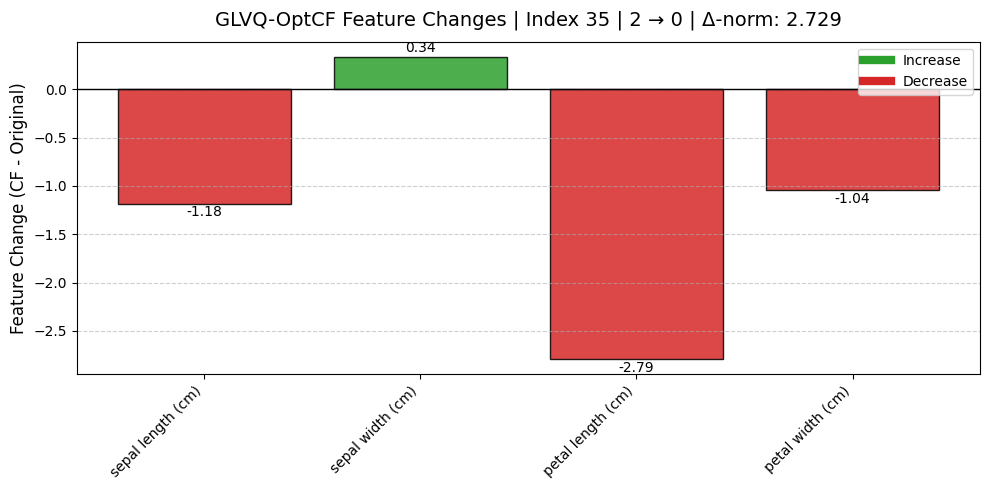

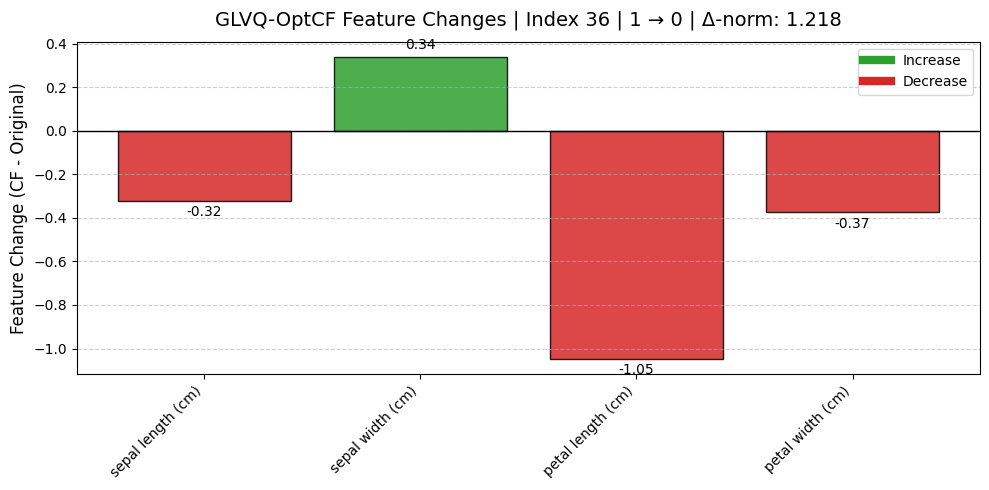

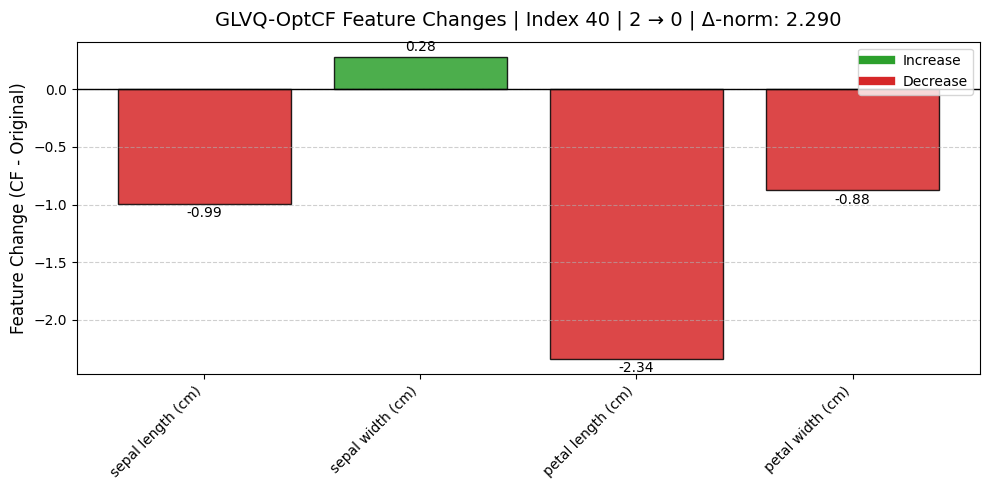

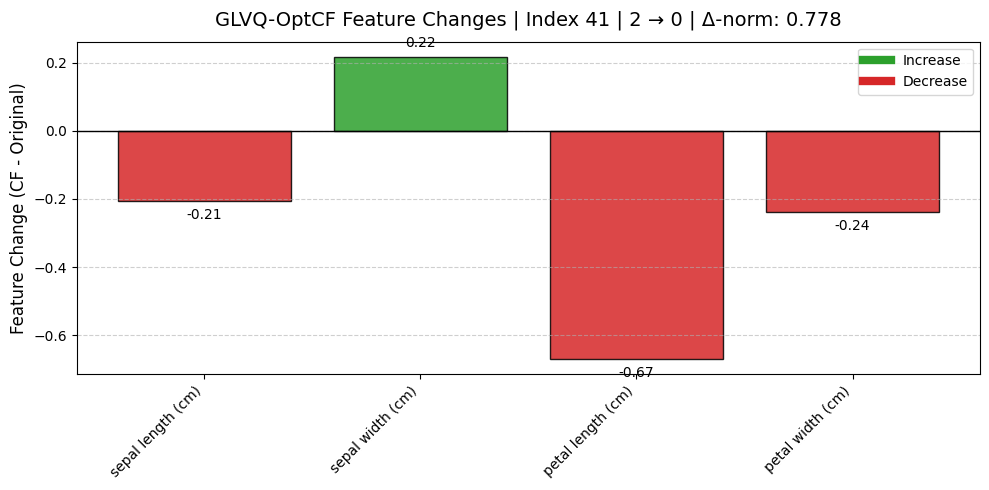

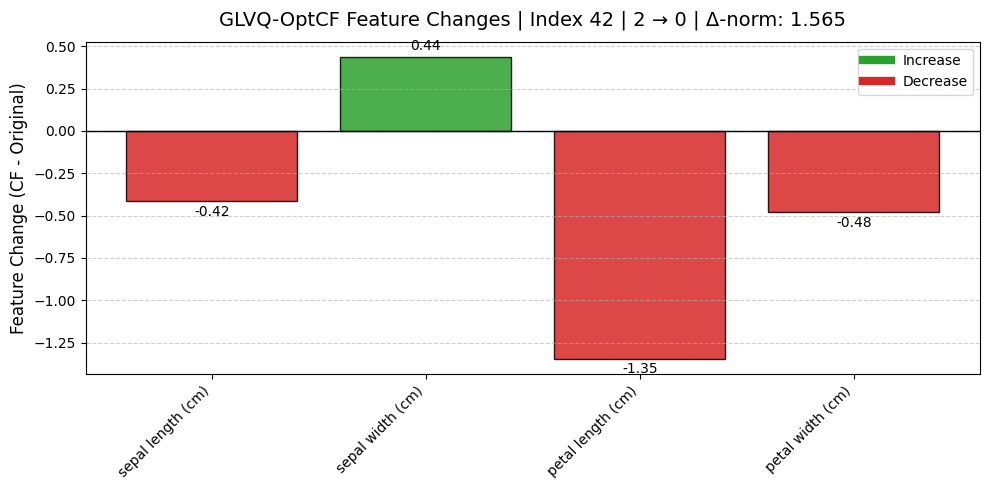

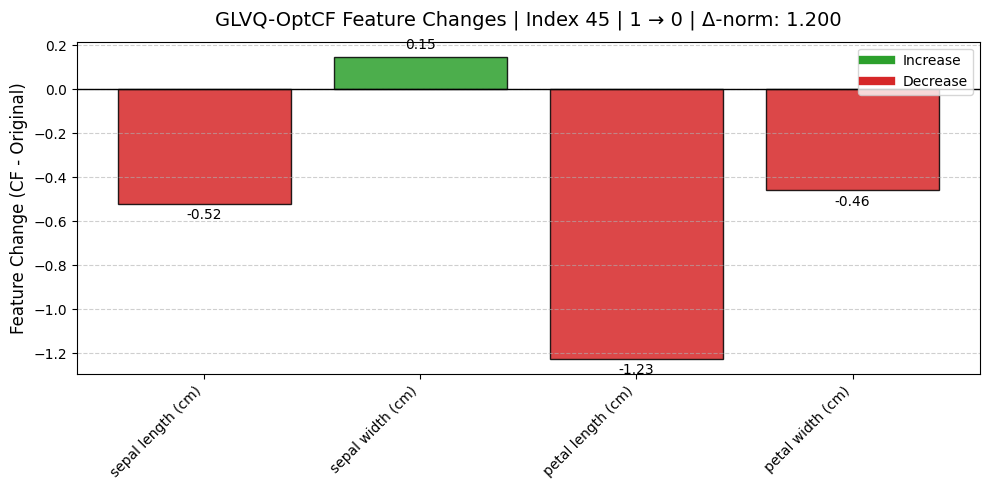

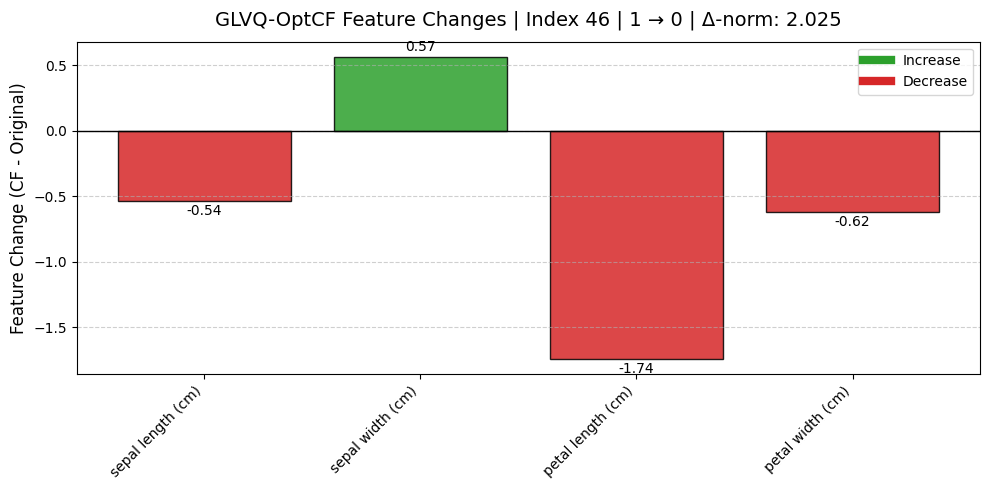

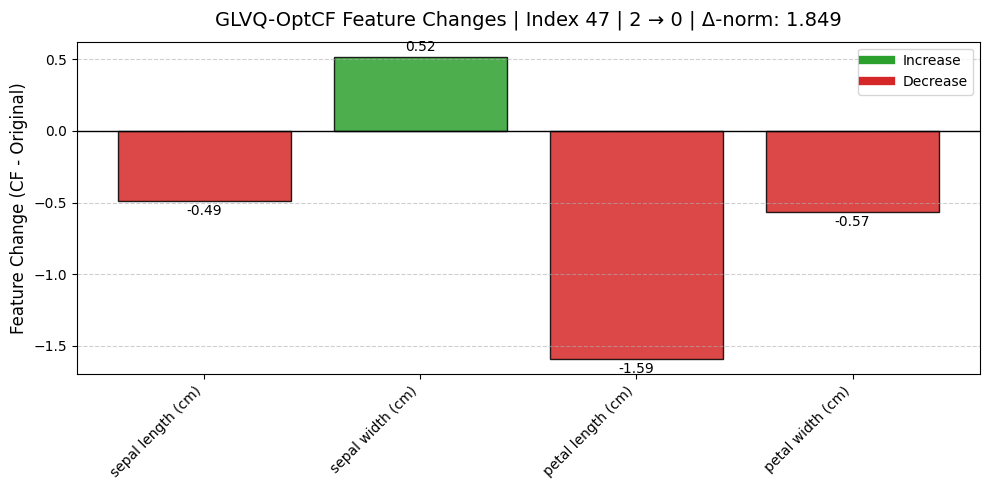

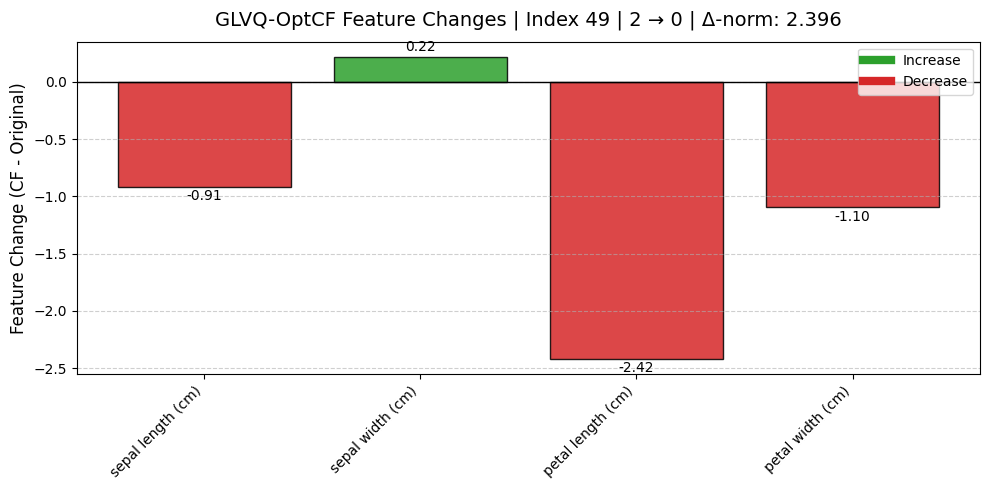

In [18]:
import matplotlib.pyplot as plt
import numpy as np

#  Filter only successful class flips
successful_cfs = cf_df[cf_df["Class Flip Success"] == "Yes"]

for _, row in successful_cfs.iterrows():
    idx = int(row["Index"])
    x_sample = X_test[idx]
    orig_vals = scaler.inverse_transform([x_sample])[0]

    y_orig = model.predict([x_sample])[0]
    y_target = row.get("Target Prediction", 0)  # fallback if column is named differently

    if y_target == y_orig:
        continue  # Skip if no class flip is needed

    try:
        x_cf, delta, m_val = generate_cf_glvq_constrained(
            model, x_sample, y_target=int(y_target), C=1.0
        )
        cf_vals = scaler.inverse_transform([x_cf])[0]
        changes = cf_vals - orig_vals
        delta_norm = np.linalg.norm(delta)

        # Plotting
        plt.figure(figsize=(10, 5))
        bars = plt.bar(
            feature_names,
            changes,
            color=['#2ca02c' if val >= 0 else '#d62728' for val in changes],
            edgecolor='black',
            alpha=0.85
        )

        plt.axhline(0, color='black', linewidth=1)
        plt.title(
            f"GLVQ-OptCF Feature Changes | Index {idx} | {y_orig} → {int(y_target)} | Δ-norm: {delta_norm:.3f}",
            fontsize=14,
            pad=12
        )
        plt.ylabel("Feature Change (CF - Original)", fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.6)

        # Add numerical value annotations
        for bar, val in zip(bars, changes):
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.02 * np.sign(bar.get_height()),
                f"{val:.2f}",
                ha='center',
                va='bottom' if val >= 0 else 'top',
                fontsize=10
            )

        # Legend (Optional)
        plt.legend(handles=[
            plt.Line2D([0], [0], color='#2ca02c', lw=6, label='Increase'),
            plt.Line2D([0], [0], color='#d62728', lw=6, label='Decrease')
        ], loc='upper right')

        plt.tight_layout()
        plt.show()
        # plt.savefig(f"cf_feature_changes_idx{idx}.png")  # Optional: save as image

    except Exception as e:
        print(f"❌ Could not compute CF for index {idx} — {str(e)}")
